In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

#### Import data and labels

In [2]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'
  
with open(data_path+'/simulation.npy', 'rb') as f:    #'+str(sim_num)+'
    data_in = np.load(f)
with open(data_path+'/inner_ph.npy', 'rb') as g:      #'+str(sim_num)+'
    inner_ph_in = np.load(g)

### Preprocessing

In [3]:
###### parameters #################
root_threshold = 10
###### fixed parameters ###########
n_cam_in_grain = 54
cam_side_length = 31
renormalisation = 10000
###################################

data = (data_in).reshape(-1, n_cam_in_grain, cam_side_length**2)
print('data shape (n_data, n_cam, cam_shape) :',data.shape)

print('\n' + '################ process data from root file ################') 
  
inner_ph = inner_ph_in.reshape(n_cam_in_grain, -1)    #inner_ph_in.reshape(76,-1)  
print('inner photons shape :',inner_ph.shape)
  
overthr_inner_evn = np.unique( np.where( inner_ph > root_threshold )[1] )
label = np.zeros(inner_ph_in.size).reshape(-1, n_cam_in_grain)

for evn in overthr_inner_evn:
    for cam in np.unique( np.where( inner_ph.T[evn] > root_threshold ) ):
        label[evn][cam] = 1
print('labelled blind :', np.where(label==1)[0].size)

data shape (n_data, n_cam, cam_shape) : (1000, 54, 961)

################ process data from root file ################
inner photons shape : (54, 1000)
labelled blind : 742


#### Split into test and training sets

In [4]:
train_data, test_data = data[:800], data[800:]
train_label, test_label = label[:800], label[800:]

train_data.shape

(800, 54, 961)

In [5]:
train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data /= renormalisation
test_data /= renormalisation

train_label = train_label.flatten()
test_label = test_label.flatten()

train_label_ohe = to_categorical(train_label,2)
test_label_ohe = to_categorical(test_label,2)

test_label_ohe[0]

array([1., 0.], dtype=float32)

## First NN

Epoch 1/40
270/270 [==============================] - 2s 6ms/step - loss: 0.1127 - accuracy: 0.9855 - val_loss: 0.0441 - val_accuracy: 0.9895
Epoch 2/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0503 - accuracy: 0.9877 - val_loss: 0.0454 - val_accuracy: 0.9897
Epoch 3/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0496 - accuracy: 0.9878 - val_loss: 0.0427 - val_accuracy: 0.9902
Epoch 4/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0486 - accuracy: 0.9876 - val_loss: 0.0420 - val_accuracy: 0.9897
Epoch 5/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0477 - accuracy: 0.9880 - val_loss: 0.0412 - val_accuracy: 0.9904
Epoch 6/40
270/270 [==============================] - 1s 5ms/step - loss: 0.0477 - accuracy: 0.9881 - val_loss: 0.0431 - val_accuracy: 0.9883
Epoch 7/40
270/270 [==============================] - 2s 6ms/step - loss: 0.0469 - accuracy: 0.9883 - val_loss: 0.0414 - val_accuracy: 0.9906
Epoch 

<AxesSubplot: >

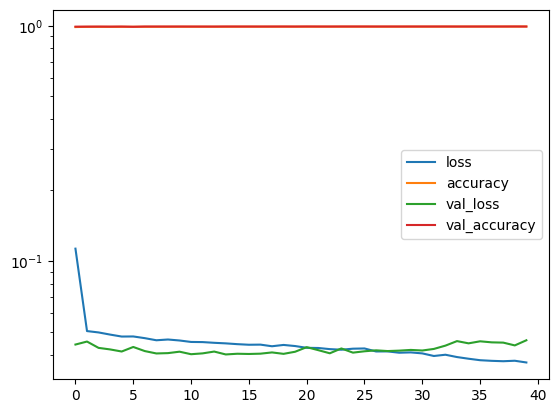

In [6]:
n_hidden = 128
n_classes = 2

train_data_0 = train_data.reshape(-1, cam_side_length*cam_side_length)
test_data_0 = test_data.reshape(-1, cam_side_length*cam_side_length)

model0 = Sequential()
model0.add(Dense(n_hidden, 
                 input_shape=(cam_side_length*cam_side_length,), 
                 name='dense_layer', 
                 activation='relu'))
model0.add(Dropout(0.3))
model0.add(Dense(n_hidden,  
                 name='dense_layer_2', 
                 activation='relu'))
model0.add(Dropout(0.3))
model0.add(Dense(n_classes,  
                 name='dense_layer_3', 
                 activation='softmax'))

model0.compile(optimizer='adam', 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history_callback0 = model0.fit(train_data_0, train_label_ohe,
                              batch_size=128, epochs=40,
                              verbose=1, validation_split=0.2)
pd.DataFrame(history_callback0.history).plot(logy=True)

In [12]:
test_loss0, test_acc0 = model0.evaluate(test_data_0, test_label_ohe)
print('Test accuracy:', test_acc0)

pred0 = model0.predict(test_data_0)

338/338 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9874
Test accuracy: 0.987407386302948
338/338 [==============================] - 1s 2ms/step


In [13]:
pred0 = np.around(pred0) 
    
pred0_dec = np.dot(pred0, np.array([0,1], dtype='float32'))
pred0_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))
    
# print(pred0_dec.shape)
# print(np.where(pred0_dec==1))
# print(np.where(pred0_lab==1))

print('labelled :', np.where(pred0_lab==1)[0].size)  
print('predicted :',  np.where(pred0_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred0_lab==1), np.where(pred0_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred0_lab==0), np.where(pred0_dec==1)).shape[0])    
print('false negative :', np.intersect1d(np.where(pred0_lab==1), np.where(pred0_dec==0)).shape[0]) 
print('\n')
print(np.where(pred0_dec==1))
print(np.where(pred0_lab==1))

write_pdf = True
if write_pdf :
    pdf = PdfPages('./nn.pdf')
    for evn in np.intersect1d(np.where(pred0_lab==1), np.where(pred0_dec==1)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred0_lab==0), np.where(pred0_dec==1)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('FALSE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred0_lab==1), np.where(pred0_dec==0)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('FALSE negative')
        pdf.savefig(fig)
        plt.close()
    pdf.close()
  

labelled : 164
predicted : 52
true positive : 40
false positive : [  355   358  3521  4303  4690  4761  5605  5899  6534  6535 10551 10552]
false negative : 124


(array([   97,   218,   230,   355,   358,   480,  1075,  1108,  1650,
        1656,  2562,  2816,  2829,  2831,  3286,  3407,  3521,  4216,
        4303,  4380,  4690,  4761,  4875,  4876,  5164,  5356,  5605,
        5899,  6534,  6535,  6689,  7121,  7149,  7270,  7271,  7564,
        7697,  7708,  8039,  8432,  8979,  9025,  9064,  9400,  9514,
        9572, 10107, 10210, 10518, 10549, 10551, 10552], dtype=int64),)
(array([   64,    73,    97,   218,   230,   260,   274,   285,   301,
         427,   428,   479,   480,   482,   811,   987,  1075,  1108,
        1122,  1444,  1515,  1604,  1607,  1608,  1643,  1644,  1650,
        1656,  1785,  1797,  1850,  1947,  2095,  2318,  2319,  2403,
        2439,  2445,  2486,  2488,  2500,  2551,  2552,  2561,  2562,
        2616,  2674,  2685,  2773,  2816,  2817,  2818,  2820, 

## NN


In [9]:
# train_data_nn = train_data.reshape(-1, cam_side_length*cam_side_length)
# test_data_nn = test_data.reshape(-1, cam_side_length*cam_side_length)

# my_network = models.Sequential([
#   layers.Dense(350, activation='relu'),
#   layers.Dense(350, activation='relu'),
#   layers.Dense(350, activation='relu'),
#   layers.Dense(3, activation='softmax')
# ])

# # the compilation step
# my_network.compile(optimizer='rmsprop',
#                    loss='sparse_categorical_crossentropy',
#                    metrics=['accuracy'])

In [10]:
# history_callback = my_network.fit(train_data_nn, train_label, epochs=10)
# pd.DataFrame(history_callback.history).plot()

In [11]:
# test_loss, test_acc = my_network.evaluate(test_data_nn, test_label)
# print('test_acc:', test_acc)